In [1]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from etrade.spot.forecast.plan_a.constructor import *
from etrade.spot.forecast.yieldindex import zero_quantile
from etrade.spot.forecast import yieldindex
from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from  data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, SkewNormalDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps, quantile_RMSE

from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.mfk.skewnd2 import dof_snd_fitter

from scipy.optimize import differential_evolution

from matplotlib import pyplot
import json

In [2]:

with open(r"..\forecast\plan_a\data\market_simulator_3.json", "r") as f:
    train_data = json.loads(f.read())
    
with open(r"..\forecast\plan_a\data\market_simulator_4.json", "r") as f:
    test_data = json.loads(f.read())

In [3]:
train_data =numpy.asarray(train_data["data"])
test_data =numpy.asarray(test_data["data"])

In [4]:
market_len = 1
l = 3 * market_len + market_len
def zscore_p(x):
    x = numpy.asarray(x)
    m = numpy.mean(x, axis=0)
    s = numpy.std(x, ddof=1, axis=0)
    return m,s

def zscore(x, m, s):
    x = numpy.asarray(x)
    m = numpy.asarray(m)
    s = numpy.asarray(s)
    return numpy.column_stack((
            (x[:,:l]-m[:l]) / s[:l], x[:,l]
    ))

def minmax_p(x):
    x = numpy.asarray(x)
    mmax = numpy.max(x, axis=0)
    mmin = numpy.min(x, axis=0)
    return mmin, mmax

def minmax(x, mmin, mmax):
    x = numpy.asarray(x)
    mmin = numpy.asarray(mmin)
    mmax = numpy.asarray(mmax)
    # return (x-mmin) / (mmax-mmin)
    return numpy.column_stack((
            (x[:,:l]-mmin[:l]) / (mmax[:l]-mmin[:l]), x[:,l]
    ))
    
    
    

In [5]:
m,s= zscore_p(train_data)
zscored_t = zscore(train_data, m, s)
zscored_x = zscore(test_data, m, s)

mmin,mmax = minmax_p(train_data)
minmaxed_t = minmax(train_data, mmin, mmax)
minmaxed_x = minmax(test_data, mmin, mmax)

In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
# p = MLPRegressor(
#     hidden_layer_sizes=[50] * 4,
#     activation="relu",
#     solver="lbfgs",
#     # alpha=1e-3,
#     # learning_rate_init=1e-3
# )
p = RandomForestRegressor(
    # alpha=0.999
)
# p = KernelRidge(
#     # kernel="linear",
#     # alpha=1e-3
# )
p.fit(
    zscored_t[:,:l],
    zscored_t[:,l]
)

RandomForestRegressor()

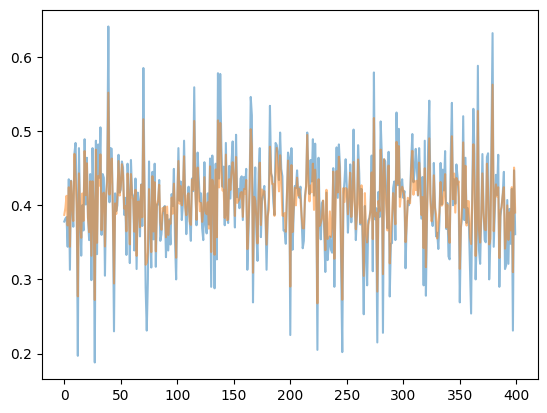

In [7]:

pyplot.plot(zscored_t[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_t[:,:l]), alpha=0.5)

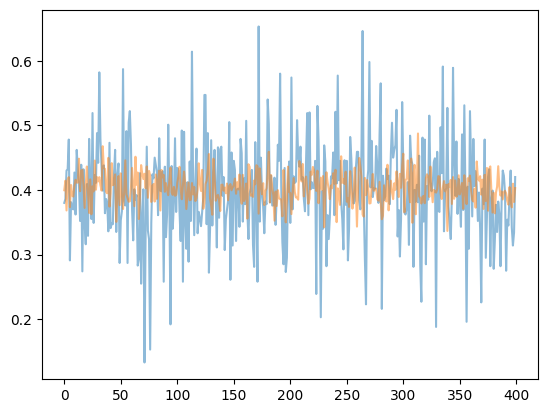

In [8]:

pyplot.plot(zscored_x[:,l], alpha=0.5)
pyplot.plot(p.predict(zscored_x[:,:l]), alpha=0.5)

In [9]:
p.score(zscored_x[:,:l], zscored_x[:,l])

-0.13328682246828993

In [10]:
p.score(zscored_t[:,:l], zscored_t[:,l])

0.8431153505680044

In [11]:
train_data

array([[2.19040653, 3.22797879, 2.42298232, 0.61970027, 0.378     ],
       [3.86218243, 1.88873091, 2.55176657, 1.0905395 , 0.382     ],
       [3.55444   , 3.27493735, 1.38582862, 0.73831998, 0.384     ],
       ...,
       [1.84474208, 1.86296578, 1.29463038, 0.93934737, 0.231     ],
       [6.4615023 , 3.34011059, 1.12705813, 1.77753066, 0.447     ],
       [1.19118588, 1.41735583, 1.77236565, 0.73639262, 0.361     ]])

In [14]:
print(minmaxed_t.tolist())

[[0.08914631163211532, 0.1417291154081181, 0.14178878857485616, 0.0368980969281987, 0.378], [0.1571851224786343, 0.07730921116010338, 0.15030298448172535, 0.29912644350661877, 0.382], [0.14466046006635022, 0.1439878953446233, 0.07322039381475207, 0.1029619429471398, 0.384], [0.2266318831294198, 0.10156267793221443, 0.156111096743953, 0.11230997920034415, 0.344], [0.510600917577455, 0.11201304452502699, 0.18077293095833408, 0.10954277396231543, 0.435], [0.3027545861826244, 0.09700040321622425, 1.0, 0.03631166852007857, 0.313], [0.1303432498050884, 0.04983499643224509, 0.3260889987628517, 0.041935392065142324, 0.433], [0.08498877247930411, 0.1179122104579521, 0.29238531771546317, 0.1859723827122939, 0.4], [0.2984106376131764, 0.05610770403514999, 0.1294804863499673, 0.13408638343567555, 0.371], [0.1708388587741738, 0.047238759930508974, 0.058856111872695197, 0.12438586090056385, 0.47], [0.08301303189044767, 0.0393436633109116, 0.214942904464791, 0.09703337382636287, 0.484], [0.3080838665